To DO:
* Make run equal to original simulate function

In [94]:
import jax
from jax import random
from jax import numpy as np
from jax import vmap, jit, grad
from jax.experimental import optimizers
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [95]:
# load data
import pickle

with open('go_nogo_200.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
y_go = d['y_go'] #/ d['y_go'].max() # Normalize...
y_go[150:] = 0 
y_nogo = d['y_nogo'] * 0

dict_keys(['J0', 'J', 'w', 'I_go', 'I_nogo', 'y_go', 'y_nogo'])


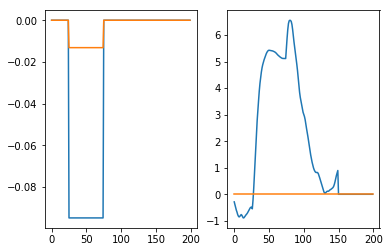

In [96]:
N = d['I_go'].shape[0]
Jinit = d['J0']
J = d['J']
w = d['w']
zN = np.zeros((25,N))
zNl = np.zeros((125,N))
z1 = np.zeros((1))
x_go = np.concatenate((zN, np.repeat(d['I_go'][None], axis=0, repeats=50), zNl))
x_nogo = np.concatenate((zN, np.repeat(d['I_nogo'][None], axis=0, repeats=50), zNl))
f, ax = plt.subplots(1, 2)
ax[0].plot(x_go.mean(1))
ax[0].plot(x_nogo.mean(1))
ax[1].plot(y_go)
ax[1].plot(y_nogo)

## Define network

In [97]:
def step_rnn(J, h, x):
    """ Perform one forward step """
    h = np.dot(J, h) + x
    return np.tanh(h)

def output(w, h):
    return np.dot(w, h)

batched_output = vmap(output, (None, 0))

def run(J, w, x_t):
    """ Simulate RNN for T time steps
        params : dict with keys J, w
        x_t : inputs, of shape (T, )
    """
    T, N = x_t.shape
    # Random initial condition
    key = random.PRNGKey(onp.random.randint(low=0, high=10**3))
    h = random.normal(key, shape=(N, ))
    h_t = []
    for x in x_t:
        h = 0.5 * h + np.dot(J, np.tanh(h)) + x #step_rnn(J, h, x)
        h_t.append(h)
    h_t = np.array(h_t)
    o_t = batched_output(w, np.tanh(h_t))
    return h_t, o_t

batched_run = vmap(run, (None, None,0))

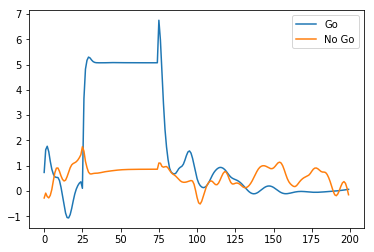

In [98]:
h_t, o_t = batched_run(d['J'], d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
h_t, o_t = batched_run(d['J'], d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.legend()

In [99]:
def compute_loss(J, w, inputs, targets):
    """ Inputs of size (nb_inputs, T, N) """
    _, outputs = batched_run(J, w, inputs)
    loss = np.mean((outputs - targets) ** 2)
    return loss

#loss_jit = jit(compute_loss)
#loss_jit(d['J'], d['w'], x_go[None], d['y_go'][None])

In [100]:
def update_weights(i, opt_state, opt_update, inputs, targets):
    J = optimizers.get_params(opt_state)
    def training_loss(J, w, x, y):
        return compute_loss(J,w,x,y)
    grads = grad(training_loss)(J,w,inputs,targets)
    return opt_update(i, grads, opt_state)

#update_weights_jit = jit(update_weights, static_argnums=(2,))

In [101]:
# Always show the same pattern
inputs = np.concatenate((x_go[None], x_nogo[None]))
targets = np.concatenate((y_go[None], y_nogo[None]))

In [104]:
gamma = 0.99
decay_fun = optimizers.exponential_decay(step_size=1e-3, decay_steps=1, decay_rate=gamma)
opt_init, opt_update = optimizers.adam(decay_fun) 
init_J = d['J0']
opt_state = opt_init(init_J)
#update_weights_jit(0, opt_state, opt_update, inputs, targets)

In [105]:
# don't jit, its super slow on cpu 
loss_hist = []
print_every = 10
for t in range(200):
    t0 = time.time()
    opt_state = update_weights(t, opt_state, opt_update, inputs, targets)
    t1 = time.time()
    if t % print_every == 0:
        J = optimizers.get_params(opt_state)
        l = compute_loss(J, w, inputs, targets)
        s = "Step {} in {:0.2f} sec, step size {:0.5f}, loss {:0.3f}"
        print(s.format(t, t1 - t0, decay_fun(t), l))
        loss_hist.append(l)
    

Step 0 in 1.02 sec, step size 0.00100, loss 4.096
Step 10 in 0.83 sec, step size 0.00090, loss 1.207
Step 20 in 0.93 sec, step size 0.00082, loss 0.350
Step 30 in 0.85 sec, step size 0.00074, loss 0.280
Step 40 in 0.85 sec, step size 0.00067, loss 0.203
Step 50 in 0.96 sec, step size 0.00061, loss 0.500
Step 60 in 0.81 sec, step size 0.00055, loss 0.169
Step 70 in 0.87 sec, step size 0.00049, loss 0.106
Step 80 in 0.94 sec, step size 0.00045, loss 0.282
Step 90 in 0.86 sec, step size 0.00040, loss 0.123
Step 100 in 0.91 sec, step size 0.00037, loss 0.127
Step 110 in 0.90 sec, step size 0.00033, loss 0.072
Step 120 in 0.90 sec, step size 0.00030, loss 0.081
Step 130 in 0.95 sec, step size 0.00027, loss 0.054
Step 140 in 0.84 sec, step size 0.00024, loss 0.105
Step 150 in 0.83 sec, step size 0.00022, loss 0.119
Step 160 in 0.96 sec, step size 0.00020, loss 0.068
Step 170 in 0.81 sec, step size 0.00018, loss 0.065
Step 180 in 0.96 sec, step size 0.00016, loss 0.055
Step 190 in 0.87 sec, s

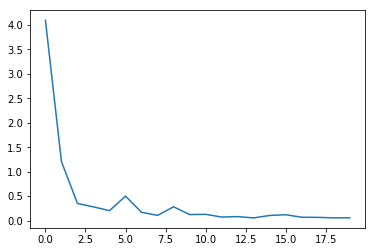

In [106]:
plt.plot(loss_hist)

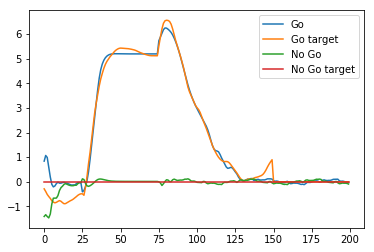

In [107]:
h_t, o_t = batched_run(J, d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
plt.plot(y_go, label = 'Go target')
h_t, o_t = batched_run(J, d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.plot(y_nogo, label = 'No Go target')

plt.legend()

0.20283732958362008


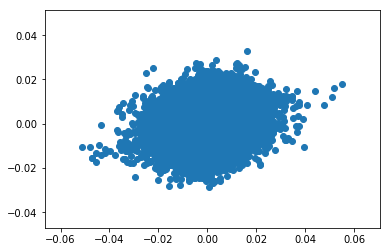

In [129]:
J_update = J - init_J
n = d['I_go'] 
m = d['w']
J_orig_update = 0.1*np.dot(m[:,None], n[None,:])
plt.scatter(J_orig_update.flatten(), J_update.flatten())
rho = onp.corrcoef(J_orig_update.flatten(), J_update.flatten())[0,1]
print(rho)